In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
from torch.distributions.categorical import Categorical

import pytorch_lightning as pl
from pytorch_lightning.metrics import functional
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
import scipy.stats as stats
from torchsummary import summary
from functools import partial

import boda
#from boda.generator.parameters import StraightThroughParameters
#from boda.generator import FastSeqProp, AdaLead
#from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm
from boda.model.mpra_basset import MPRA_Basset
from boda.common import constants, utils
#from boda.generator.energy import BaseEnergy

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

# from main import unpack_artifact, model_fn
# from pymeme import streme, parse_streme_output

In [2]:
def get_truths_only(datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    if dataset=='val':
        data_generator = datamodule.val_dataloader()
    if dataset=='test':
        data_generator = datamodule.test_dataloader()
    if dataset=='chr_train':
        data_generator = datamodule.chr_train_dataloader()
    if dataset=='chr_val':
        data_generator = datamodule.chr_val_dataloader()
    if dataset=='chr_test':
        data_generator = datamodule.chr_test_dataloader()
    if dataset=='synth_train':
        data_generator = datamodule.synth_train_dataloader()
    if dataset=='synth_val':
        data_generator = datamodule.synth_val_dataloader()
    if dataset=='synth_test':
        data_generator = datamodule.synth_test_dataloader()

    truths = []
    for local_batch, local_targets in data_generator:
        truths.append(local_targets.numpy())
    truths_array = np.concatenate(truths, axis=0)
    #Unscale:
    if datamodule.rescale is not None:
        a, b = datamodule.rescale
        mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
        truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
    return truths_array

def get_predictions(model, datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    elif dataset=='val':
        data_generator = datamodule.val_dataloader()
    elif dataset=='test':
        data_generator = datamodule.test_dataloader()
    elif dataset=='chr_train':
        data_generator = datamodule.chr_train_dataloader()
    elif dataset=='chr_val':
        data_generator = datamodule.chr_val_dataloader()
    elif dataset=='chr_test':
        data_generator = datamodule.chr_test_dataloader()
    elif dataset=='synth_train':
        data_generator = datamodule.synth_train_dataloader()
    elif dataset=='synth_val':
        data_generator = datamodule.synth_val_dataloader()
    elif dataset=='synth_test':
        data_generator = datamodule.synth_test_dataloader()
    elif dataset=='extra':
        data_generator = datamodule.synth_test_dataloader()
    model.eval()
    truths = []
    preds = []
    if next(model.parameters()).is_cuda:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch.cuda()).cpu().detach().numpy())
            truths.append(local_targets.numpy())
    else:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch).detach().numpy())
            truths.append(local_targets.numpy())
    preds_array = np.concatenate(preds, axis=0)
    truths_array = np.concatenate(truths, axis=0)
    # #Unscale:
    # if datamodule.rescale is not None:
    #     a, b = datamodule.rescale
    #     mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
    #     truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
    #     preds_array = (preds_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
        preds_array = preds_array * stds + means
    return truths_array, preds_array

def get_scatterplots(truths_array, preds_array, specificity_fn, celltypes=['K562', 'HepG2', 'SKNSH']):
    fig = plt.figure(figsize=(25,6))
    pearsons = []
    spearmans = []
    num_figures = len(celltypes) + 1 
    for dim in range(num_figures - 1):
        plt.subplot(1, num_figures, dim+1)
        pearson = stats.pearsonr(truths_array[:,dim], preds_array[:,dim])[0]
        pearsons.append(pearson)
        spearman = stats.spearmanr(truths_array[:,dim], preds_array[:,dim])[0]
        spearmans.append(spearman)
        sns.scatterplot(x=truths_array[:,dim], y=preds_array[:,dim], color='C'+str(dim), alpha=0.1)
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        lim_min = min( (truths_array[:,dim]).min(), (preds_array[:,dim]).min() ) - 0.1
        lim_max = max( (truths_array[:,dim]).max(), (preds_array[:,dim]).max() ) + 0.1
        plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.title(f'{celltypes[dim]} | Spearman {round(spearman, 2)}, Pearson {round(pearson, 2)}')
    plt.subplot(1, num_figures, num_figures)
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6', alpha=0.1)
    lim_min = min( specificity_truths.min(), specificity_preds.min() ) - 0.1
    lim_max = max( specificity_truths.max(), specificity_preds.max() ) + 0.1
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
    #plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.draw()
    plt.draw()
    print('')
    print('----------------------------------------------')
    print(f'Pearsons: {pearsons}, average: {round(np.mean(pearsons), 2)}')
    print(f'Spearmans: {spearmans}, average: {round(np.mean(spearmans), 2)}')
    print('----------------------------------------------')

def get_specificity_corr(truths_array, preds_array, specificity_fn):
    fig = plt.figure(figsize=(6,6))
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6')
    lim_min = min( specificity_truths.min(), specificity_preds.min() ) - 0.1
    lim_max = max( specificity_truths.max(), specificity_preds.max() ) + 0.1
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
    #plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.draw()
    
def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float64), dim=1).numpy()
    shannon = np.sum(- p_c * np.log(p_c), axis=1)
    return shannon

def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def single_entropy_score(x, num_classes=3):
    p_c = nn.Softmax(dim=0)(x)
    shannon = torch.sum(- p_c * torch.log(p_c), axis=0)
    return 1 - shannon / np.log(num_classes)

In [3]:
# from boda.graph.utils import pearson_correlation as Pearson_correlation
# from boda.graph.utils import shannon_entropy as Shannon_entropy

In [4]:
#! gsutil cp gs://syrgoth/data/MPRA_ALL_v3.txt ./
#! gsutil cp gs://syrgoth/data/MPRA_ALL_200.txt ./

In [5]:
class MPRA_DataModule(pl.LightningDataModule):
    
    @staticmethod
    def add_data_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        group  = parser.add_argument_group('Data Module args')
        
        group.add_argument('--datafile_path', type=str, required=True)
        group.add_argument('--data_project', type=str, nargs='+', default=['BODA', 'UKBB'])
        group.add_argument('--project_column', type=str, default='data_project')
        group.add_argument('--sequence_column', type=str, default='nt_sequence')
        group.add_argument('--activity_columns', type=str, nargs='+', default=['K562', 'HepG2.neon', 'SKNSH'])
        group.add_argument('--exclude_chr_train', type=str, nargs='+', default=[''])
        group.add_argument('--val_chrs', type=str, nargs='+', default=['17','19','21','X'])
        group.add_argument('--test_chrs', type=str, nargs='+', default=['7','13'])
        group.add_argument('--chr_column', type=str, default='chr')
        group.add_argument('--std_multiple_cut', type=float, default=6.0)
        group.add_argument('--up_cutoff_move', type=float, default=3.0)
        group.add_argument('--synth_chr', type=str, default='synth')
        group.add_argument('--synth_val_pct', type=float, default=10.0)
        group.add_argument('--synth_test_pct', type=float, default=10.0)
        group.add_argument('--synth_seed', type=int, default=0)
        group.add_argument('--batch_size', type=int, default=32, 
                           help='Number of examples in each mini batch')         
        group.add_argument('--padded_seq_len', type=int, default=600, 
                           help='Desired total sequence length after padding') 
        group.add_argument('--num_workers', type=int, default=8, 
                           help='number of gpus or cpu cores to be used') 
        group.add_argument('--normalize', type=utils.str2bool, default=False, 
                           help='apply standard score normalization') 
        return parser
    
    @staticmethod
    def add_conditional_args(parser, known_args):
        return parser
    
    @staticmethod
    def process_args(grouped_args):
        data_args    = grouped_args['Data Module args']
        return data_args

    def __init__(self,
                 datafile_path,
                 data_project=['BODA', 'UKBB'],
                 project_column='data_project',
                 sequence_column='nt_sequence',
                 activity_columns=['K562_mean', 'HepG2_mean', 'SKNSH_mean'],
                 exclude_chr_train = [''],
                 val_chrs=['17','19','21','X'],
                 test_chrs=['7','13'],
                 chr_column='chr',
                 std_multiple_cut=6.0,
                 up_cutoff_move=4.0,
                 synth_chr='synth',
                 synth_val_pct=10.0,
                 synth_test_pct=10.0,
                 synth_seed=0,
                 batch_size=32,
                 padded_seq_len=600, 
                 num_workers=8,
                 normalize=False,
                 doubling_factor=0,
                 train_reverse_comp=False,
                 activity_threshold=1.5,
                 **kwargs):       
        """
        Takes a .txt file with a column cotaining DNA sequences,
        column(s) containing log2FC, and a chromosome column.
        Preprocesses, tokenizes, creates Train/Val/Test dataloaders.

        Parameters
        ----------
        datafile_path : str
            Path to the .txt file with the data (space-separated)..
        data_project : str, optional
            DESCRIPTION. The default is ['BODA', 'UKBB'].
        project_column : str, optional
            DESCRIPTION. The default is 'data_project'.
        sequence_column : str, optional
            Name of the column of the DNA sequences. The default is 'nt_sequence'.
        activity_columns : list, optional
            List of names of the columns with log2FC. The default is ['K562_mean', 'HepG2_mean', 'SKNSH_mean'].
        exclude_chr_train : list, optional
            List of chromosomes to be excluded from train. The default is [''].
        val_chrs : list, optional
            DESCRIPTION. The default is ['17','19','21','X'].
        test_chrs : list, optional
            DESCRIPTION. The default is ['7','13'].
        chr_column : str, optional
            Name of the column of the chromosome number. The default is 'chr'.
        std_multiple_cut : float, optional
            DESCRIPTION. The default is 6.0.
        up_cutoff_move : float, optional
            DESCRIPTION. The default is 3.0.
        synth_chr : str, optional
            DESCRIPTION. The default is 'synth'.
        synth_val_pct : float, optional
            DESCRIPTION. The default is 10.0.
        synth_test_pct : float, optional
            DESCRIPTION. The default is 10.0.
        synth_seed : int, optional
            DESCRIPTION. The default is 0.
        batch_size : int, optional
            Number of examples in each mini batch. The default is 32.
        padded_seq_len : int, optional
            Desired total sequence length after padding. The default is 600.
        num_workers : int, optional
            number of gpus or cpu cores to be used, right?. The default is 8.
        normalize : bool, optional
            DESCRIPTION. The default is False.
        **kwargs : TYPE
            DESCRIPTION.

        Returns
        -------
        None.

        """
        
        super().__init__()
        self.datafile_path = datafile_path
        self.data_project = data_project
        self.project_column = project_column
        self.sequence_column = sequence_column
        self.activity_columns = activity_columns
        self.exclude_chr_train = set(exclude_chr_train) - {''}
        self.val_chrs = set(val_chrs) - {''}
        self.test_chrs = set(test_chrs) - {''}
        self.chr_column = chr_column
        self.std_multiple_cut = std_multiple_cut
        self.up_cutoff_move = up_cutoff_move
        self.synth_chr = synth_chr
        self.synth_val_pct = synth_val_pct
        self.synth_test_pct = synth_test_pct
        self.synth_seed = synth_seed
        self.batch_size = batch_size
        self.padded_seq_len = padded_seq_len        
        self.num_workers = num_workers
        self.normalize = normalize
        self.doubling_factor = doubling_factor
        self.train_reverse_comp = train_reverse_comp
        self.activity_threshold = activity_threshold
        
        self.pad_column_name = 'padded_seq'
        self.tensor_column_name = 'onehot_seq'
        self.activity_means = None
        self.activity_stds = None
        self.synth_chr_as_set = {synth_chr}
        
        self.padding_fn = partial(utils.row_pad_sequence,
                                  in_column_name=self.sequence_column,
                                  padded_seq_len=self.padded_seq_len
                                  )
        self.tokenize_fn = partial(utils.row_dna2tensor,
                                   in_column_name=self.pad_column_name
                                   )
        self.chr_dataset_train = None
        self.chr_dataset_val = None
        self.chr_dataset_test = None
        self.synth_dataset_train = None
        self.synth_dataset_val = None
        self.synth_dataset_test = None
                
    def setup(self, stage='train'):
        dataset_train = None
        #--------- parse data from MPRA file ---------
        columns = [self.sequence_column, *self.activity_columns, self.chr_column, self.project_column]
        temp_df = utils.parse_file(file_path=self.datafile_path, columns=columns)

        temp_df = temp_df[temp_df[self.project_column].isin(self.data_project)].reset_index(drop=True)
        
        #--------- cut-off and standard score norm ---------
        means = temp_df[self.activity_columns].mean().to_numpy()
        stds  = temp_df[self.activity_columns].std().to_numpy()
        
        up_cut   = means + stds * self.std_multiple_cut + self.up_cutoff_move
        down_cut = means - stds * self.std_multiple_cut 
        
        non_extremes_filter_up = (temp_df[self.activity_columns] < up_cut).to_numpy().all(axis=1)
        temp_df = temp_df.loc[non_extremes_filter_up]
        
        non_extremes_filter_down = (temp_df[self.activity_columns] > down_cut).to_numpy().all(axis=1)
        temp_df = temp_df.loc[non_extremes_filter_down]
        
        self.num_examples = len(temp_df)
        if self.normalize:   
            temp_df[self.activity_columns] = (temp_df[self.activity_columns] - means) / stds
            self.activity_means = torch.Tensor(means)
            self.activity_stds = torch.Tensor(stds)        
        
        #--------- print cut-off info ---------
        print('-'*50)
        print('')
        for idx, cell in enumerate(self.activity_columns):
            cell_name = cell.rstrip('_mean')
            top_cut_value = round(up_cut[idx], 2)
            bottom_cut_value = round(down_cut[idx], 2)
            print(f'{cell_name} | top cut value: {top_cut_value}, bottom cut value: {bottom_cut_value}')
        print('')    
        num_up_cuts   = np.sum(~non_extremes_filter_up)
        num_down_cuts = np.sum(~non_extremes_filter_down)
        print(f'Number of examples discarded from top: {num_up_cuts}')
        print(f'Number of examples discarded from bottom: {num_down_cuts}')
        print('')
        print(f'Number of examples available: {self.num_examples}')
        print('')
        print('-'*50)
        print('')
        
        #--------- pad sequences, convert to one-hots ---------
        print('Padding sequences...')
        temp_df[self.pad_column_name] = temp_df.apply(self.padding_fn, axis=1)
        print('Tokenizing sequences...')
        
        temp_df[self.tensor_column_name] = temp_df.apply(self.tokenize_fn, axis=1)
        
        #--------- split dataset in train/val/test sets ---------
        print('Creating train/val/test datasets...')
        all_chrs = set(temp_df[self.chr_column])
        self.train_chrs = all_chrs - self.val_chrs - self.test_chrs - self.synth_chr_as_set - self.exclude_chr_train
        
        if len(self.train_chrs) > 0:
            sequences_train  = list(temp_df[temp_df[self.chr_column].isin(self.train_chrs)][self.tensor_column_name])
            activities_train = temp_df[temp_df[self.chr_column].isin(self.train_chrs)][self.activity_columns].to_numpy()
            sequences_train  = torch.stack(sequences_train)
            activities_train = torch.Tensor(activities_train)    
            self.chr_dataset_train = TensorDataset(sequences_train, activities_train)
        
        if len(self.val_chrs) > 0:
            sequences_val  = list(temp_df[temp_df[self.chr_column].isin(self.val_chrs)][self.tensor_column_name])
            activities_val = temp_df[temp_df[self.chr_column].isin(self.val_chrs)][self.activity_columns].to_numpy()
            sequences_val  = torch.stack(sequences_val)
            activities_val = torch.Tensor(activities_val)  
            self.chr_dataset_val = TensorDataset(sequences_val, activities_val)
        
        if len(self.test_chrs) > 0:
            sequences_test    = list(temp_df[temp_df[self.chr_column].isin(self.test_chrs)][self.tensor_column_name])                      
            activities_test   = temp_df[temp_df[self.chr_column].isin(self.test_chrs)][self.activity_columns].to_numpy()    
            sequences_test    = torch.stack(sequences_test)        
            activities_test   = torch.Tensor(activities_test)
            self.chr_dataset_test = TensorDataset(sequences_test, activities_test)
             
        if self.synth_chr in all_chrs:
            synth_sequences  = list(temp_df[temp_df[self.chr_column].isin(self.synth_chr_as_set)][self.tensor_column_name])
            synth_activities = temp_df[temp_df[self.chr_column].isin(self.synth_chr_as_set)][self.activity_columns].to_numpy()
            synth_sequences  = torch.stack(synth_sequences)
            synth_activities = torch.Tensor(synth_activities)
            synth_dataset = TensorDataset(synth_sequences, synth_activities)
        
            synth_num_examples = synth_activities.shape[0]
            synth_val_size     = int(synth_num_examples * self.synth_val_pct // 100)
            synth_test_size    = int(synth_num_examples * self.synth_test_pct // 100)
            synth_train_size   = synth_num_examples - synth_val_size - synth_test_size  
    
            synth_dataset_split = random_split(synth_dataset,
                                               [synth_train_size, synth_val_size, synth_test_size],
                                               generator=torch.Generator().manual_seed(self.synth_seed))
            
            self.synth_dataset_train, self.synth_dataset_val, self.synth_dataset_test = synth_dataset_split

            if self.chr_dataset_train is None:
                if self.synth_chr not in self.exclude_chr_train:
                    dataset_train = self.synth_dataset_train
            elif len(self.synth_dataset_train) > 0:
                dataset_train = ConcatDataset([self.chr_dataset_train, self.synth_dataset_train])
            else:
                dataset_train = self.chr_dataset_train
                
            if self.chr_dataset_val is None:
                self.dataset_val = self.synth_dataset_val
            else:
                self.dataset_val = ConcatDataset([self.chr_dataset_val, self.synth_dataset_val])
                
            if self.chr_dataset_test is None:
                self.dataset_test = self.synth_dataset_test
            else:
                self.dataset_test = ConcatDataset([self.chr_dataset_test, self.synth_dataset_test])
        else:
            self.dataset_train = self.chr_dataset_train
            self.dataset_val = self.chr_dataset_val
            self.dataset_test = self.chr_dataset_test
        
        # if (dataset_train is not None) and self.train_reverse_comp:
        #     print(f'Adding reverse complements...')
        #     reverse_complements = torch.stack(
        #             [reverse_complement(dataset_train[i][0]) for i in range(len(self.dataset_train))]
        #             )
        #     revese_activities = torch.stack(
        #             [dataset_train[i][1] for i in range(len(self.dataset_train))]
        #             )
        #     reverse_dataset = TensorDataset(reverse_complements, revese_activities)
        #     self.dataset_train = ConcatDataset([self.dataset_train , reverse_dataset])

        if (dataset_train is not None) and (self.doubling_factor > 0):
            print('Weighting training samples...')
#             score_threshold = 0.3
#             samples_weight = [single_entropy_score(example[1]) for example in dataset_train]
#             samples_weight = np.array(samples_weight)
#             extra_idxs = list(np.where(samples_weight > score_threshold)[0])

            #activity_threshold = 1.4
            samples_weight = [torch.max(example[1]) for example in dataset_train]
            samples_weight = np.array(samples_weight)
            extra_idxs = list(np.where(samples_weight > self.activity_threshold)[0])

            extra_sequences = torch.stack([dataset_train[idx][0] for idx in extra_idxs])
            extra_activities = torch.stack([dataset_train[idx][1] for idx in extra_idxs])
            extra_dataset = TensorDataset(extra_sequences, extra_activities)
            extended_dataset = dataset_train
            for i in range(self.doubling_factor):
                 extended_dataset = ConcatDataset([extended_dataset , extra_dataset])
            dataset_train = extended_dataset 
            self.extra_dataset = extra_dataset                      
        
        self.dataset_train = dataset_train

        #--------- print train/val/test info ---------
        if self.dataset_train is not None:
            if self.doubling_factor > 0:
                train_size = len(self.dataset_train) - len(self.extra_dataset) * self.doubling_factor
            else:
                train_size = len(self.dataset_train)
        else: train_size = 0

        if self.train_reverse_comp:
            self.train_size = int(train_size / 2)
        else:
            self.train_size = train_size

        if self.dataset_val is not None: self.val_size = len(self.dataset_val)
        else: self.val_size = 0
            
        if self.dataset_test is not None: self.test_size = len(self.dataset_test)
        else: self.test_size = 0
            
        train_pct = round(100 * self.train_size / self.num_examples, 2)
        val_pct   = round(100 * self.val_size / self.num_examples, 2)
        test_pct  = round(100 * self.test_size / self.num_examples, 2)
        excluded_size = self.num_examples - self.train_size - self.val_size - self.test_size
        excluded_pct = round(100 * excluded_size / self.num_examples, 2)
        print('-'*50)
        print('')
        print(f'Number of examples in train: {self.train_size} ({train_pct}%)')
        print(f'Number of examples in val:   {self.val_size} ({val_pct}%)')
        print(f'Number of examples in test:  {self.test_size} ({test_pct}%)')
        print('')
        if excluded_size > 0:
            print(f'Excluded from train: {excluded_size} ({excluded_pct})%')
        try:
            print(f'Duplicating in train: {len(self.extra_dataset)} x {self.doubling_factor}')
        except:
            pass
        print(f'(Actual size of training set: {len(self.dataset_train)})')
        print('-'*50)       

    def add_reverse_complements(self):
        print('-'*50)
        print('')
        print(f'Adding reverse complements...')
        n_training_examples = len(self.dataset_train)
        reverse_complements = torch.stack(
                    [reverse_complement(self.dataset_train[i][0]) for i in range(n_training_examples)]
                    )
        reverse_activities = torch.stack(
                [self.dataset_train[i][1] for i in range(n_training_examples)]
                )
        reverse_dataset = TensorDataset(reverse_complements, reverse_activities)
        self.dataset_train = ConcatDataset([self.dataset_train , reverse_dataset])       
        print('')
        print(f'Size of training set after augmentation: {len(self.dataset_train)}')
        print('')

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)
    
    def synth_train_dataloader(self):
        return DataLoader(self.synth_dataset_train, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)
    
    def synth_val_dataloader(self):
        return DataLoader(self.synth_dataset_val, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def synth_test_dataloader(self):
        return DataLoader(self.synth_dataset_test, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)
    
    def chr_train_dataloader(self):
        return DataLoader(self.chr_dataset_train, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)
    
    def chr_val_dataloader(self):
        return DataLoader(self.chr_dataset_val, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def chr_test_dataloader(self):
        return DataLoader(self.chr_dataset_test, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)
        
    def extra_dataloader(self):
        return DataLoader(self.extra_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

In [6]:
%%time
datamodule = MPRA_DataModule(datafile_path='MPRA_ALL_v3.txt',
                             data_project=['BODA', 'UKBB', 'GTEX'],  #'BODA', 'UKBB', 'GTEX'
                             project_column='data_project',
                             sequence_column='nt_sequence',
                             activity_columns=['K562_mean', 'HepG2_mean', 'SKNSH_mean'],
                             val_chrs=['19','21','X'], #'17','19','21','X' | '11', '15', 'Y'
                             test_chrs =['7', '13'],  #'7', '13' | '4','12'
                             chr_column='chr',
                             std_multiple_cut=3.5,
                             up_cutoff_move=7.0,
                             synth_chr='synth',
                             synth_val_pct=0,
                             synth_test_pct=99.98,
                             synth_seed=0,
                             batch_size=1024,
                             padded_seq_len=600, 
                             num_workers=4,
                             normalize=False,
                             doubling_factor=1,
                             activity_threshold=1.4)

if not torch.cuda.is_available():
    datamodule.numWorkers = 8

datamodule.setup()
datamodule.add_reverse_complements()

--------------------------------------------------

K562 | top cut value: 11.57, bottom cut value: -3.57
HepG2 | top cut value: 11.08, bottom cut value: -3.16
SKNSH | top cut value: 11.45, bottom cut value: -3.62

Number of examples discarded from top: 0
Number of examples discarded from bottom: 212

Number of examples available: 792429

--------------------------------------------------

Padding sequences...
Tokenizing sequences...
Creating train/val/test datasets...
Weighting training samples...
--------------------------------------------------

Number of examples in train: 651912 (82.27%)
Number of examples in val:   60890 (7.68%)
Number of examples in test:  79627 (10.05%)

Duplicating in train: 129107 x 1
(Actual size of training set: 781019)
--------------------------------------------------
--------------------------------------------------

Adding reverse complements...

Size of training set after augmentation: 1562038

CPU times: user 3min 54s, sys: 15.9 s, total: 4min 10s
Wa

In [7]:
last_activation_fn = 'ReLU6'
extra_hidden_size = 250
seed = 12

#! gsutil cp gs://syrgoth/my-model.epoch_5-step_19885.pkl ./
pl.seed_everything(seed)
model = MPRA_Basset(basset_weights_path='my-model.epoch_5-step_19885.pkl',
                    extra_hidden_size = extra_hidden_size,
                    criterion='L1Loss', #'MSELoss', #'L1Loss', #'SmoothL1Loss',
                    last_activation=last_activation_fn,
                    sneaky_factor=2,
                    pretrained=True)

if torch.cuda.is_available():
    model.cuda()
num_gpus = torch.cuda.device_count()
summary(model, (4, 600))

Global seed set to 12


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     ConstantPad1d-1               [-1, 4, 618]               0
            Conv1d-2             [-1, 300, 600]          23,100
       BatchNorm1d-3             [-1, 300, 600]             600
        Conv1dNorm-4             [-1, 300, 600]               0
              ReLU-5             [-1, 300, 600]               0
         MaxPool1d-6             [-1, 300, 200]               0
     ConstantPad1d-7             [-1, 300, 210]               0
            Conv1d-8             [-1, 200, 200]         660,200
       BatchNorm1d-9             [-1, 200, 200]             400
       Conv1dNorm-10             [-1, 200, 200]               0
             ReLU-11             [-1, 200, 200]               0
        MaxPool1d-12              [-1, 200, 50]               0
    ConstantPad1d-13              [-1, 200, 56]               0
           Conv1d-14              [-1, 

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
print(model.extra_hidden_size, model.criterion, model.last_activation, model.sneaky_factor, datamodule.doubling_factor)

250 L1Loss() ReLU6() 2 1


In [9]:
#-------------------- Train only last layer ------------------------
model.basset_net.freeze()

model.epochs = 15
model.learning_rate = 0.05     #0.05
model.weight_decay = 1e-6      #1e-6
model.scheduler = True         #True
datamodule.batch_size = 2048   #1024

logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True)
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     logger=logger, callbacks=[lr_monitor], precision=16)

trainer.fit(model, datamodule)
trainer.test()


#------------------------ Train all layers ------------------------
model.basset_net.unfreeze()

model.epochs = 50
model.learning_rate = 1e-2   #1e-2
model.weight_decay = 1e-5    #1e-5
model.scheduler = False      #False
datamodule.batch_size = 2048  #1024

logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True) 
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     logger=logger, callbacks=[lr_monitor], precision=16) 

trainer.fit(model, datamodule)
trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | In sizes  | Out sizes
-----------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?         | ?        
1 | last_activation | ReLU6      | 0      | [1, 250]  | [1, 250] 
2 | basset_net      | Basset     | 4.9 M  | ?         | ?        
3 | output_1        | Sequential | 250 K  | [1, 1000] | [1, 1]   
4 | output_2        | Sequential | 250 K  | [1, 1000] | [1, 1]   
5 | output_3        | Sequential | 250 K  | [1, 1000] | [1, 1]   
-----------------------------------------------------------------------
751 K     Trainable params
4.9 M     Non-trainable params
5.6 M     Total params
22.411    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12


| Prediction correlation: 0.00578 | Specificity correlation: -0.00048 |
-----------------------------------------------------------------------


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.46579 | Specificity correlation: 0.26969 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69815 | Specificity correlation: 0.29043 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.46459 | Specificity correlation: 0.26664 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70206 | Specificity correlation: 0.29451 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70076 | Specificity correlation: 0.26432 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69658 | Specificity correlation: 0.28514 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69843 | Specificity correlation: 0.29551 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69924 | Specificity correlation: 0.26597 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69872 | Specificity correlation: 0.30769 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.46584 | Specificity correlation: 0.29197 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70203 | Specificity correlation: 0.30965 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70150 | Specificity correlation: 0.30183 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70123 | Specificity correlation: 0.30471 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70201 | Specificity correlation: 0.30998 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


| Prediction correlation: 0.70223 | Specificity correlation: 0.30867 |
----------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5988010764122009}
--------------------------------------------------------------------------------



  | Name            | Type       | Params | In sizes  | Out sizes
-----------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?         | ?        
1 | last_activation | ReLU6      | 0      | [1, 250]  | [1, 250] 
2 | basset_net      | Basset     | 4.9 M  | ?         | ?        
3 | output_1        | Sequential | 250 K  | [1, 1000] | [1, 1]   
4 | output_2        | Sequential | 250 K  | [1, 1000] | [1, 1]   
5 | output_3        | Sequential | 250 K  | [1, 1000] | [1, 1]   
-----------------------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.411    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12


| Prediction correlation: 0.66497 | Specificity correlation: 0.24944 |
----------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: RuntimeWarning: You are using `LearningRateMonitor` callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.50282 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.51465 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28539 | Specificity correlation: 0.51674 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53038 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54463 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54023 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54397 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53749 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54976 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57100 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28711 | Specificity correlation: 0.56125 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.52727 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56735 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55398 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.29068 | Specificity correlation: 0.57371 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28937 | Specificity correlation: 0.56035 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56207 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56604 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28959 | Specificity correlation: 0.57169 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.29089 | Specificity correlation: 0.55518 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56883 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56455 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.29103 | Specificity correlation: 0.57382 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56412 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56214 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28943 | Specificity correlation: 0.56961 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56565 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56572 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57217 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57705 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.29037 | Specificity correlation: 0.56915 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56926 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55490 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58479 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56541 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56706 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54303 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57161 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56071 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57648 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56639 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56889 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57325 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57973 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58209 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55940 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56970 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58899 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55885 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


| Prediction correlation: 0.00000 | Specificity correlation: 0.57596 |
----------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4092579185962677}
--------------------------------------------------------------------------------


[{'test_loss': 0.4092579185962677}]


----------------------------------------------
Pearsons: [0.9025258633883518, 0.8977115320052219, 0.8946062380281354], average: 0.9
Spearmans: [0.8350089601208023, 0.8475752720984236, 0.8395257535203096], average: 0.84
----------------------------------------------

----------------------------------------------
Pearsons: [0.8830475499290734, 0.8738816284704443, 0.8756863030592077], average: 0.88
Spearmans: [0.7876812572507003, 0.8095847756926332, 0.8092870594602265], average: 0.8
----------------------------------------------

----------------------------------------------
Pearsons: [0.8257772928821345, 0.8177034377372652, 0.8147660581277908], average: 0.82
Spearmans: [0.7506033778071238, 0.7598763768368001, 0.7685975820997818], average: 0.76
----------------------------------------------


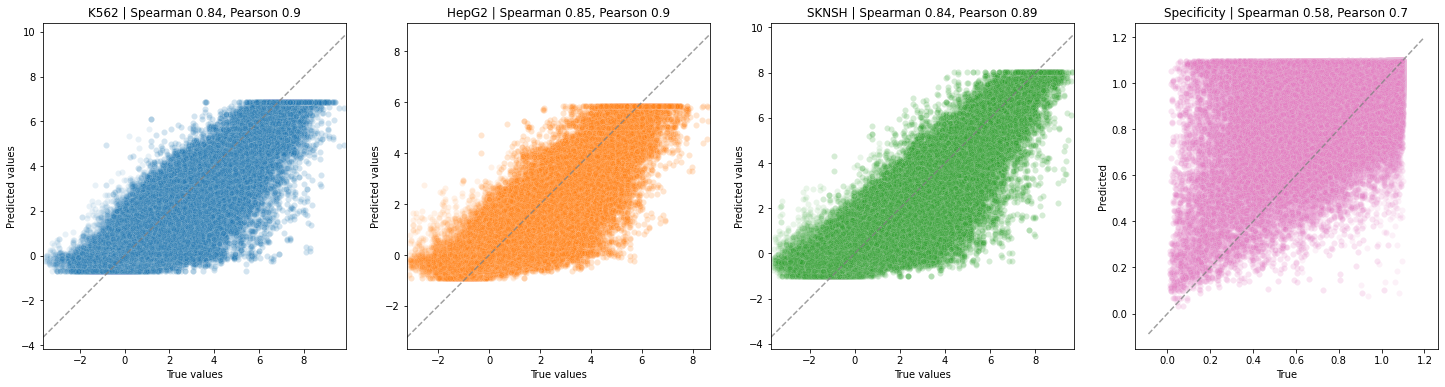

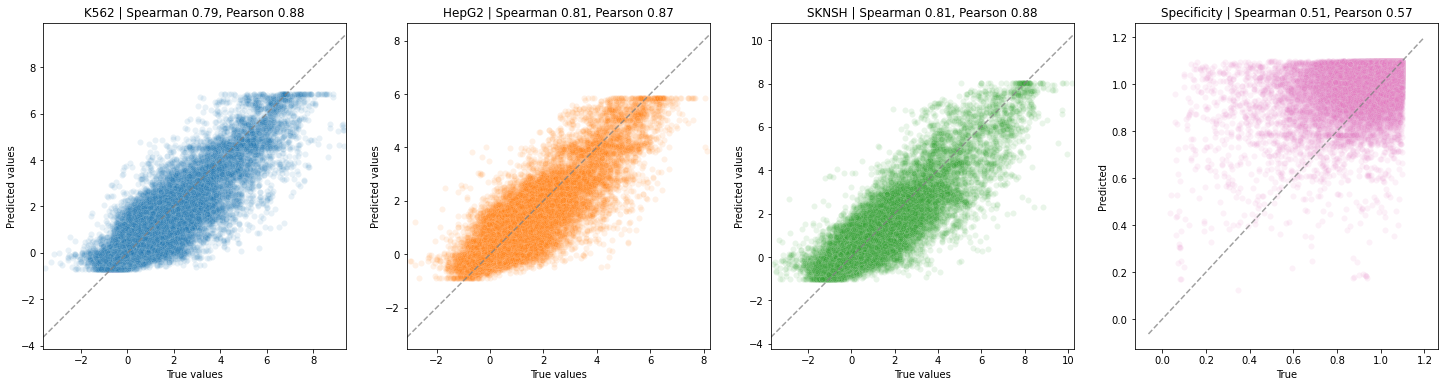

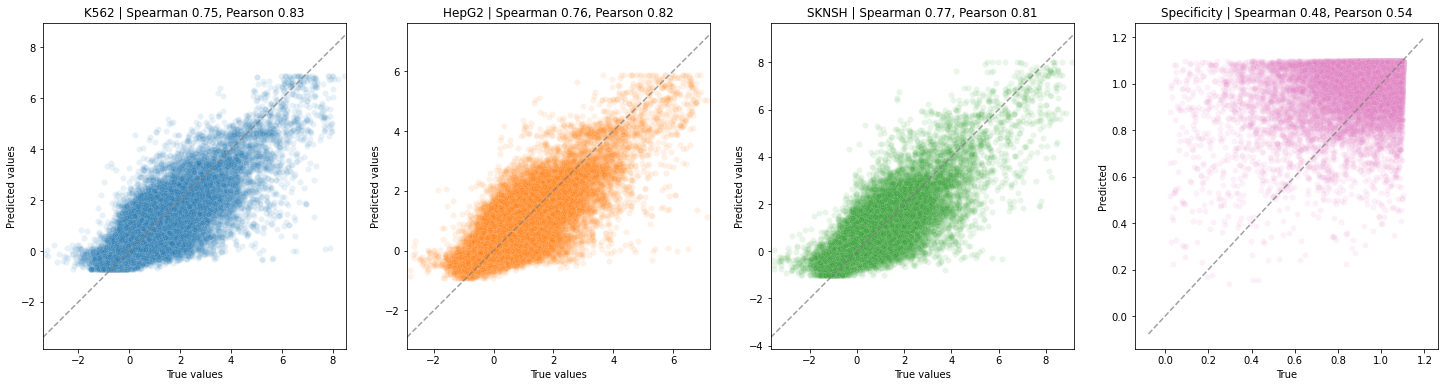

In [10]:
if not next(model.parameters()).is_cuda:
    model.cuda()

train_truths, train_preds = get_predictions(model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(model, datamodule, dataset='val')
test_truths, test_preds = get_predictions(model, datamodule, dataset='test')
get_scatterplots(train_truths, train_preds, specificity_fn=entropy)
get_scatterplots(val_truths, val_preds, specificity_fn=entropy)
get_scatterplots(test_truths, test_preds, specificity_fn=entropy)

In [14]:
#------------------------ Train all layers ------------------------
model.basset_net.unfreeze()

model.epochs = 3
model.learning_rate = 1e-3   #1e-2
model.weight_decay = 1e-5    #1e-5
model.scheduler = False      #False
datamodule.batch_size = 2048  #1024

logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True) 
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     logger=logger, callbacks=[lr_monitor], precision=16) 

trainer.fit(model, datamodule)
trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | In sizes  | Out sizes
-----------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?         | ?        
1 | last_activation | ReLU6      | 0      | [1, 250]  | [1, 250] 
2 | basset_net      | Basset     | 4.9 M  | ?         | ?        
3 | output_1        | Sequential | 250 K  | [1, 1000] | [1, 1]   
4 | output_2        | Sequential | 250 K  | [1, 1000] | [1, 1]   
5 | output_3        | Sequential | 250 K  | [1, 1000] | [1, 1]   
-----------------------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.411    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12


| Prediction correlation: 0.86341 | Specificity correlation: 0.57414 |
----------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: RuntimeWarning: You are using `LearningRateMonitor` callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.61905 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


| Prediction correlation: 0.00000 | Specificity correlation: 0.61033 |
----------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3856652081012726}
--------------------------------------------------------------------------------


[{'test_loss': 0.3856652081012726}]


----------------------------------------------
Pearsons: [0.9384021854721455, 0.9348761661184648, 0.9286478218212312], average: 0.93
Spearmans: [0.8702266300770181, 0.8854817459034965, 0.8763294408010952], average: 0.88
----------------------------------------------

----------------------------------------------
Pearsons: [0.8968913869619832, 0.8904558139205401, 0.8889251863044765], average: 0.89
Spearmans: [0.8105213418976063, 0.8310977887920153, 0.8266962403192529], average: 0.82
----------------------------------------------

----------------------------------------------
Pearsons: [0.8470206381535312, 0.839263249056247, 0.8311045885279931], average: 0.84
Spearmans: [0.7762523272931032, 0.785724085911148, 0.7910590681510079], average: 0.78
----------------------------------------------


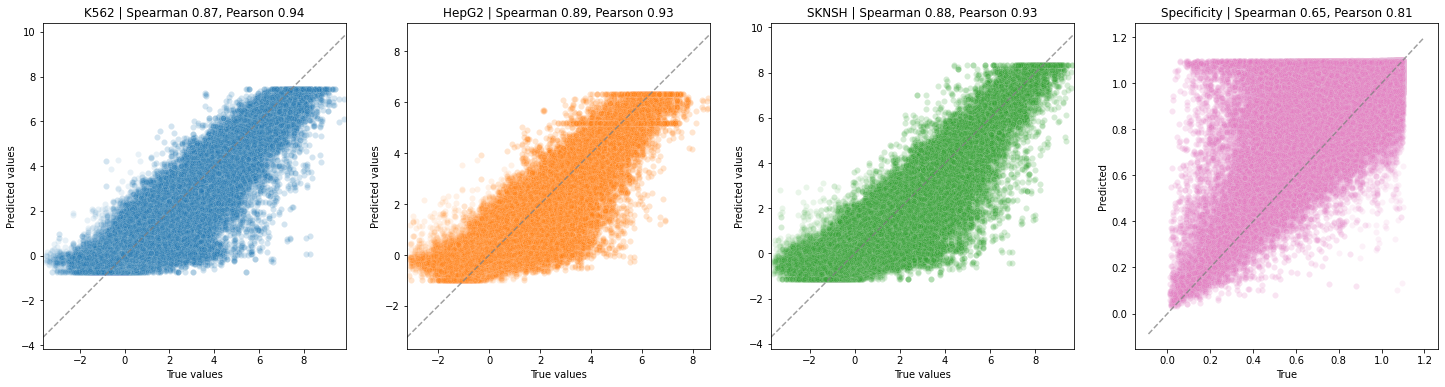

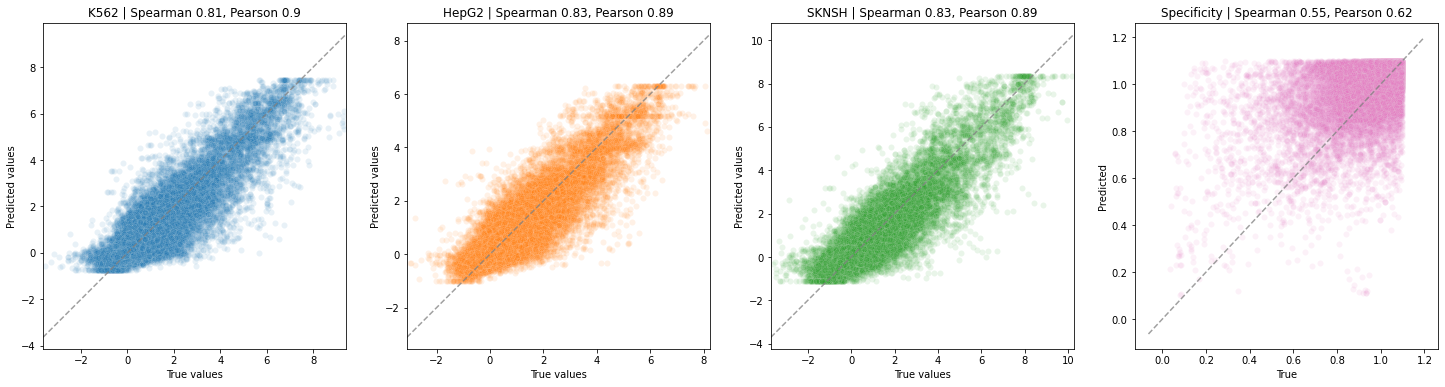

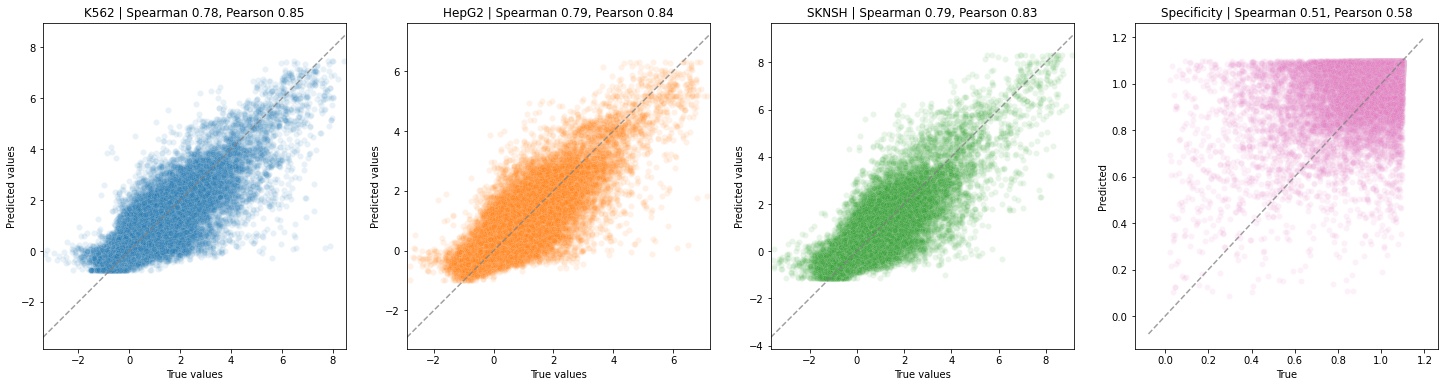

In [15]:
if not next(model.parameters()).is_cuda:
    model.cuda()

train_truths, train_preds = get_predictions(model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(model, datamodule, dataset='val')
test_truths, test_preds = get_predictions(model, datamodule, dataset='test')

get_scatterplots(train_truths, train_preds, specificity_fn=entropy)
get_scatterplots(val_truths, val_preds, specificity_fn=entropy)
get_scatterplots(test_truths, test_preds, specificity_fn=entropy)


----------------------------------------------
Pearsons: [0.8578057942842998, 0.8579107679255653, 0.8491714085370722], average: 0.85
Spearmans: [0.7725479577201472, 0.7982790649792469, 0.7965294455187614], average: 0.79
----------------------------------------------

----------------------------------------------
Pearsons: [0.8014073474686604, 0.7936364716226165, 0.7791969173473993], average: 0.79
Spearmans: [0.7961876790164198, 0.7815067454220815, 0.7889021885884456], average: 0.79
----------------------------------------------


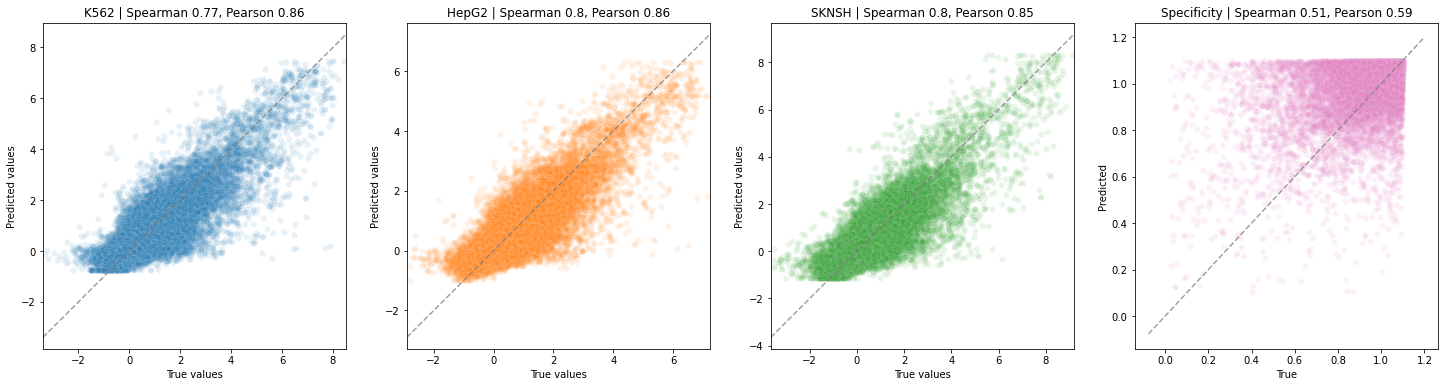

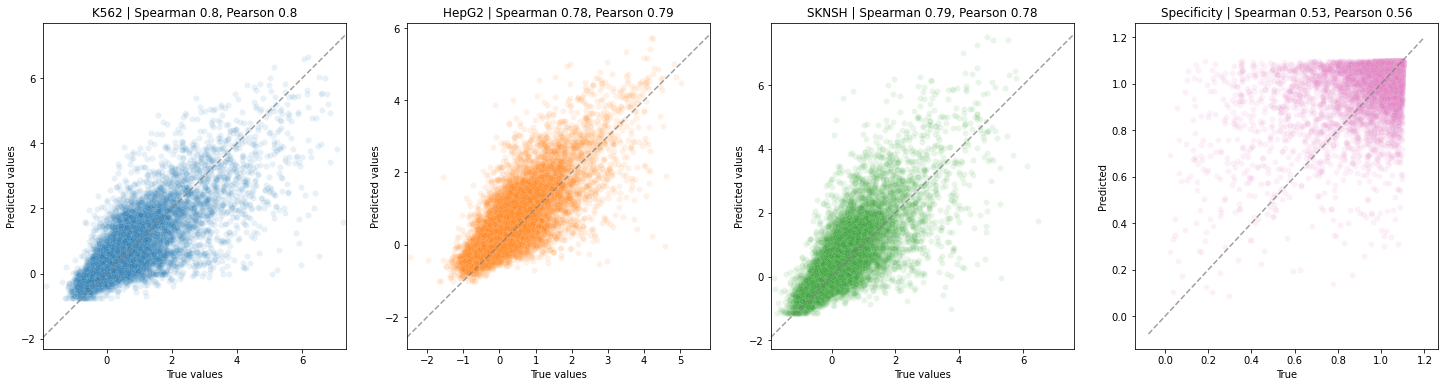

In [16]:
chr_test_truths, chr_test_preds = get_predictions(model, datamodule, dataset='chr_test')
synth_test_truths, synth_test_preds = get_predictions(model, datamodule, dataset='synth_test')
get_scatterplots(chr_test_truths, chr_test_preds, specificity_fn=entropy)
get_scatterplots(synth_test_truths, synth_test_preds, specificity_fn=entropy)

In [17]:
len(datamodule.synth_dataset_train)

3

In [ ]:
print(model.extra_hidden_size, model.criterion, model.last_activation, model.sneaky_factor, datamodule.doubling_factor)
name = "manual_checkpoint_multioutput_"
name = name + f'lasthidden{model.extra_hidden_size}'
name = name + f'_{model.criterion}'.rstrip('Loss()')
name = name + f'_{model.last_activation}'.rstrip('()')
name = name + f'_sneak{model.sneaky_factor}'
name = name + f'_double{datamodule.doubling_factor}'
# name += '_ExpAct'
name += '_' + ''.join(constants.STANDARD_NT)
name += '_gtex'
name += '_noNorm_lessVal_activity_1_4'
name += '.ckpt'
print(name)

In [ ]:
trainer.save_checkpoint(name)

In [ ]:
#------------------------ Train all layers ------------------------
model.basset_net.unfreeze()

model.epochs = 10
model.learning_rate = 5e-4   #1e-2
model.weight_decay = 1e-5    #1e-5
model.scheduler = False      #False
datamodule.batch_size = 2048  #1024

logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True) 
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     logger=logger, callbacks=[lr_monitor], precision=16) 

trainer.fit(model, datamodule)
trainer.test()

In [ ]:
if not next(model.parameters()).is_cuda:
    model.cuda()

train_truths, train_preds = get_predictions(model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(model, datamodule, dataset='val')
test_truths, test_preds = get_predictions(model, datamodule, dataset='test')

get_scatterplots(train_truths, train_preds, specificity_fn=entropy)
get_scatterplots(val_truths, val_preds, specificity_fn=entropy)
get_scatterplots(test_truths, test_preds, specificity_fn=entropy)